<a href="https://colab.research.google.com/github/chikitkin/dls_project/blob/main/dls_project_chikitkin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numba
import numpy as np
from tqdm.notebook import tqdm
from ipywidgets import interact, fixed
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.4)

from sklearn.decomposition import PCA

import torch
from torch import nn
from torch.utils.data import DataLoader
from google.colab import files

# Введение

Цель данного иследования: попробовать применить несколько архитектур нейронных сетей для аппроксимации различных зависимостей и отображений, порождаемых точным решением краевой задачи для двумерного уравнения Пуассона:
$$
u_t = u_{xx} + u_{yy} + f(x, y), \; (x,y) \in \Omega = [-1, 1]^2 \\
u|_{\partial \Omega} = 0
$$

$u(t, x, y)$ - неизвестная функция. Нас будет интересовать стационарное решение, предел нестационарного:  $u(t \to \infty, x, y)$.

Существует много численных методов для решения этой задачи, например, конечно-разностные методы. Однако, для получения стационарного решения требуется много шагов по времени/итераций, что требует больших вычислительных затрат.

В последние годы появились статьи, в которых машинное обучение используют для замены стандартных методов, либо для ускорения их сходимости. Чаще всего применяются сверточные сети, т.к. решение на сетке и значения $f(x,y)$ на сетке - это просто картинки с одним каналом, причем как правило довольно гладкие, поэтому можно почти напряму применять подходы из Computer Vision. 

В этом проекте тестируется несколько подходов для решения 2-х задач:

1. По "картинке" значений $f(x,y)$ на равномерной сетке предсказать точное решение задачи. Для обучения используются случайные функции $f(x,y)$ из некоторого семейства и соответствующие им точные решения. 

2. Для конкретной правой части $f(x,y)$ по последовательности приближенных решений на последовательных шагах по времени (которые даёт точный конечно-разностный метод) предсказать решение "в будущем" - при больших значениях $t$.

# Базовый численный метод

Функция в окошке ниже реализует явную конечно-разностную схему для решения уравнения
$$
u_t = u_{xx} + u_{yy} + f(x,y)
$$
которая имеет вид:
$$
u^{n+1} = u^n + \frac{\Delta t}{h^2}(u_{i+1,j} + u_{i-1,j} + u_{i, j+1} + u_{i, j-1} - 4 u_{i,j}) + \Delta t f_{ij}
$$
Здесь $i,j$ - это индексы сеточных узлов по координатам $x,y$ соответственно, $n$ - номер шага по времени, $\Delta t$ - шаг по времени. В явном методе для устойчивости должно выполняться $\Delta t \approx h^2$.

In [ ]:
def get_next_step(u, h, tau, f):
    """
    u --- (N + 1, N + 1) array
    h --- space step
    tau --- time step
    """

    N = len(u) - 1
    x_index = np.repeat(np.arange(1, N)[:, np.newaxis], 
                                N-1, axis=1)
    y_index = np.repeat(np.arange(1, N)[np.newaxis, :], 
                            N-1, axis=0)
    
    right_side = (u[x_index + 1, y_index] + u[x_index, y_index + 1] + \
               u[x_index - 1, y_index] + u[x_index, y_index -1] - 4 * u[x_index, y_index]) * tau / h ** 2 + tau * f[1:-1, 1:-1]
    u[x_index, y_index] += right_side

    residual = np.linalg.norm(right_side[:]/tau) * h**0.5

    return u, residual

# Отдельная функция для вычисления невязки
def compute_residual(u, h, tau, f):
    """
    u --- (N + 1, N + 1) array
    h --- space step
    tau --- time step
    """

    N = len(u) - 1
    x_index = np.repeat(np.arange(1, N)[:, np.newaxis], 
                                N-1, axis=1)
    y_index = np.repeat(np.arange(1, N)[np.newaxis, :], 
                            N-1, axis=0)
    
    vicinity = u[x_index + 1, y_index] + u[x_index, y_index + 1] + \
               u[x_index - 1, y_index] + u[x_index, y_index -1]
    
    right_side = (vicinity - 4 * u[x_index, y_index]) * tau / h ** 2 + tau * f[1:-1, 1:-1]

    residual = np.linalg.norm(right_side[:]/tau) * h**0.5

    return  residual

# 1. Предсказание решения по функции $f(x,y)$

## Генерация обучающей выборки

Идея была взята из статьи [https://arxiv.org/pdf/1712.05559.pdf] предсказываем по картинке для функции $f(x,y)$ картинку решения $u(x,y)$.  

Обучаемся на "случайных" функциях $f$. Для генерации "случайных" достаточно гладких функций используется такое семейство - частичные суммы ряда Фурье со случайными коээффициентами:
$$
f(x,y) = \sum_{n,k = 1}^{M} \frac{c^1_{nk}}{n k} \sin(n x) \cos(kx) + \frac{c^2_{nk}}{n k} \sin(n x) \sin(kx) + \frac{c^3_{nk}}{n k} \cos(n x) \cos(kx) + \frac{c^4_{nk}}{n k} \cos(n x) \sin(kx)
$$
Коэффициенты $c^j_{nk}$ - генерируются из равномерного распределения на $[-1,1]$

In [ ]:
# Функция для генерации случайной функции $f(x,y)$

def get_rand_func(size):
    r_nk = np.random.rand(4, size[0], size[1])
    r_nk = 2 * r_nk - 1 # [0, 1] -> [-1, 1]
    def rand_func(x, y):
        f = 0
        for n in range(1, size[0]+1):
            for k in range(1, size[1]+1):
                f += r_nk[0, n-1, k-1] / (n * k) * np.sin(n * x) * np.cos(k * y)\
                + r_nk[1, n-1, k-1] / (n * k) * np.sin(n * x) * np.sin(k * y)\
                + r_nk[2, n-1, k-1] / (n * k) * np.cos(n * x) * np.cos(k * y)\
                + r_nk[3, n-1, k-1] / (n * k) * np.cos(n * x) * np.sin(k * y)
        return f
    return rand_func

Нарисуем, как выглядит функция из такого семейства.

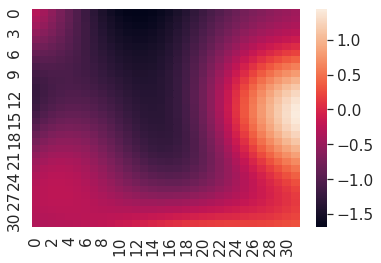

In [ ]:
N = 31
X = np.linspace(-1, 1, N + 1)
Y = np.linspace(-1, 1, N + 1)

X, Y = np.meshgrid(X, Y)

f = get_rand_func([4,4])
Z = f(X, Y)
sns.heatmap(Z)

Теперь генерируем обучающую выборку: создаём случайную функцию $f$ из описанного семейства, берём её значения на сетке - это вход. 

Потом для каждой $f$ вычисляем условно точное решение $u$ с помощью конечно-разностного метода - это выход.

In [ ]:
# Генерируем обучающую выборку

# Создаём случайную фукнцию правой части - это вход X
# делаем одно и тоже число итераций, получаем решение, это выход Y
from sklearn.model_selection import train_test_split

def generate_data_set(n_of_samples, num_of_iter = 4000, N = 31): 
    X_data = np.zeros((n_of_samples, N+1, N+1))
    Y_data = np.zeros((n_of_samples, N+1, N+1))
    
    X = np.linspace(-1, 1, N + 1)
    Y = np.linspace(-1, 1, N + 1)   
    X, Y = np.meshgrid(X, Y)

    h = 2 / N # space step
    tau = 0.1 * h**2 # time step

    for i in tqdm(range(n_of_samples)):
        f_fun = get_rand_func([4,4])
        f_val = f_fun(X, Y)

        X_data[i] = f_val
        u = np.zeros(X.shape)
        for k in range(num_of_iter):
            u, _ = get_next_step(u, h, tau, f_val)
        Y_data[i] = u
    return X_data, Y_data

Ниже - генерация обучающей выборки

In [ ]:
import time

t1 = time.clock()
n_of_samples = 500
X_data_np, Y_data_np = generate_data_set(n_of_samples)
t2 = time.clock()

print('Total time = {0:5.2e}'.format(t2 - t1))


Total time = 2.62e+02


Для примера нарисуем, как выглядит вход и выход.

Text(0.5, 1.0, 'Точное решение u(x,y)')

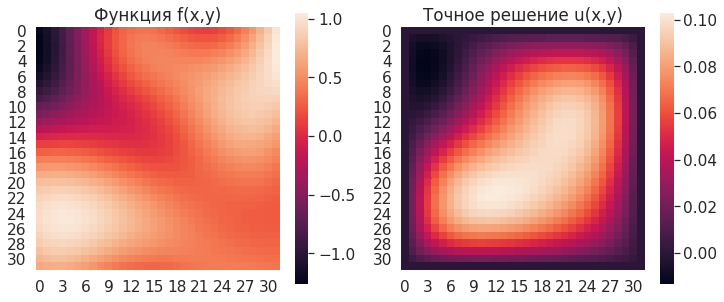

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))
sns.heatmap(X_data_np[0], ax = ax1)
sns.heatmap(Y_data_np[0], ax = ax2)
ax1.set_aspect('equal')
ax1.set_title('Функция f(x,y)')
ax2.set_aspect('equal')
ax2.set_title('Точное решение u(x,y)')

Дальше - разбиваем на train и test, и разбиваем train на батчи

In [ ]:
# Разбиваем на подвыборки
X_data = torch.from_numpy(X_data_np)
Y_data = torch.from_numpy(Y_data_np)
train_frac = 0.8 # Доля train-а
n_train = int(n_of_samples * train_frac)

X_data_train = X_data[:n_train]
Y_data_train = Y_data[:n_train]

X_data_test = X_data[n_train:]
Y_data_test = Y_data[n_train:]

# Функция для разбиения на батчи
def split_to_batches(X, Y, batch_size):
    X_split = []
    Y_split = []
    for i in range(len(X)  // batch_size):
        X_torch = X[i * batch_size : (i+1) * batch_size]
        X_torch = X_torch.view(X_torch.shape[0], 1, X_torch.shape[1], X_torch.shape[2])

        Y_torch = Y[i * batch_size : (i+1) * batch_size]
        Y_torch = Y_torch.view(Y_torch.shape[0], 1, Y_torch.shape[1], Y_torch.shape[2])

        X_split.append(X_torch.float())
        Y_split.append(Y_torch.float())


    if(len(X) > (i+1) * batch_size):
        X_torch = X[(i+1) * batch_size :]
        X_torch = X_torch.view(X_torch.shape[0], 1, X_torch.shape[1], X_torch.shape[2])

        Y_torch = Y[(i+1) * batch_size : ]
        Y_torch = Y_torch.view(Y_torch.shape[0], 1, Y_torch.shape[1], Y_torch.shape[2])

        X_split.append(X_torch.float())
        Y_split.append(Y_torch.float())
    return X_split, Y_split

# Само разбиение на батчи
X_data_train_split, Y_data_train_split = split_to_batches(X_data_train, Y_data_train, 20)

Ниже определяем loss - это просто средняя от среднеквадратичной ошибки по батчу. 

Функция ```compute_test_accuracy``` вычисляет на тестовой выборке среднюю относительную ошибку в среднеквадратичной норме.

Функция ```train_conv_net``` - обучение сети с выводом отладочной информации.

In [ ]:
def loss_fun2(y_true, y_pred):
    shape = y_true.shape
    res = torch.norm(y_true - y_pred, dim=0) / (shape[1] * shape[2] * shape[3])
    res = torch.mean(res)
    return res

def compute_test_accuracy(model, X_test, Y_test):
    # Вычисляем среднюю среднеквадратичную ошибку по всем решениям
    model.eval()
    error = 0.
    for x, y in zip(X_test, Y_test):
        y_pred = model(x.view(1, 1, N+1, N+1).to(device))
        error += torch.norm(y_pred - y.to(device)) / torch.norm(y.to(device))
    error = error / X_test.shape[0]
    return error

def train_conv_net(model, X_train, Y_train, X_test, Y_test, num_epoch = 10, 
                   loss_fun = loss_fun2, lr = 1e-4, print_freq = 1):
    loss_list = []
    opt = torch.optim.Adam(model.parameters(), lr = lr)
    for epoch in range(num_epoch):
        model.train()
        avg_loss = 0
        tot_size = 0
        for x, y in zip(X_train, Y_train):
            size = x.shape[0]
            x = x.to(device)
            y = y.to(device)

            opt.zero_grad()
            y_pred = model(x)
            loss = loss_fun(y, y_pred)
            loss.backward()
            opt.step()
            avg_loss += loss * size
            tot_size += size
        avg_loss = avg_loss / tot_size
        loss_list.append(avg_loss)
        if(epoch % print_freq == 0):
            error = compute_test_accuracy(model, X_test, Y_test)
            print('Epoch # {0:d} , loss = {1:5.2e}, mean test error = {2:5.2e}'.format(epoch, avg_loss, error))
    print('Epoch # {0:d} , loss = {1:5.2e}'.format(epoch, avg_loss))
    return loss_list

## Архитектура из статьи
Далее архитектура сети по мотивам статьи [https://arxiv.org/pdf/1712.05559.pdf].

Архитектура там безхитростная - просто последовательность сверткок + ReLU, причем свертки в статье брались с большим размером ядра (11 x 11), (7x7) ..... Это скорее всего связано с тем, что у в статье были разные размеры входа и выхода. Но я на всякий случай решил оставить большие размеры. Это позволяет сохранять размер изображения (увеличивать только число каналов) и при этом "распространять" информацию по всей области. 

In [ ]:
# Архитектура сети по аналогии со статьёй https://arxiv.org/pdf/1712.05559.pdf

class ConvNet(nn.Module):
    def __init__(self, mesh_size = 32):
        super().__init__()
        self.mesh_size = mesh_size

        self.module_list = nn.ModuleList()
        # 1
        self.module_list.append(
            nn.Sequential(
              nn.Conv2d(in_channels = 1, out_channels = 16, 
                                   kernel_size= (7, 7), padding = 3, padding_mode ='zeros'),
              nn.BatchNorm2d(16),
              nn.ReLU()
            )
        )

        # 2
        self.module_list.append(
            nn.Sequential(
              nn.Conv2d(in_channels = 16, out_channels = 32, 
                                   kernel_size= (5, 5), padding = 2, padding_mode ='zeros'),
              nn.BatchNorm2d(32),
              nn.ReLU()
            )
        )

        # 3
        self.module_list.append(
            nn.Sequential(
              nn.Conv2d(in_channels = 32, out_channels = 64, 
                                   kernel_size= (5, 5), padding = 2, padding_mode ='zeros'),
              nn.BatchNorm2d(64),
              nn.ReLU()
            )
        )
        # 4
        self.module_list.append(
            nn.Sequential(
              nn.Conv2d(in_channels = 64, out_channels = 64, 
                                   kernel_size= (5, 5), padding = 2, padding_mode ='zeros'),
              nn.BatchNorm2d(64),
              nn.ReLU()
            )
        )

        # 5
        self.module_list.append(
            nn.Sequential(
              nn.Conv2d(in_channels = 64, out_channels = 64, 
                                   kernel_size= (5, 5), padding = 2, padding_mode ='zeros'),
              nn.BatchNorm2d(64),
              nn.ReLU(), 
            )
        )

        # 6
        self.module_list.append(
            nn.Sequential(
              nn.Conv2d(in_channels = 64, out_channels = 128, 
                                   kernel_size= (5, 5), padding = 2, padding_mode ='zeros'), 
              nn.BatchNorm2d(128),
              nn.ReLU()
            )
        )

        # 7
        self.module_list.append(
            nn.Sequential(
              nn.Conv2d(in_channels = 128, out_channels = 64, 
                                   kernel_size= (1, 1), padding = 0),
              nn.BatchNorm2d(64),
              nn.ReLU()
            )
        )

        # 8
        self.module_list.append(
            nn.Sequential(
              nn.Conv2d(in_channels = 64, out_channels = 1, 
                                   kernel_size= (1, 1), padding = 0)
            )
        )

    def forward(self, v):
        u = v.to(device)
        for layer in self.module_list:
            u = layer(u)
        return u


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
print(device)

cuda


Создаём модель, и пробуем вычислить выход, чтобы отсеять ошибки.

In [ ]:
conv_net = ConvNet().to(device)

In [ ]:
u = conv_net(X_data_train[0].view(1, 1, N+1, N+1).float())

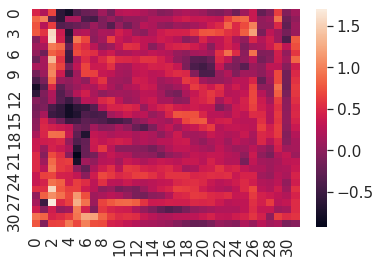

In [ ]:
sns.heatmap(u.cpu().detach().view(N+1, N+1).numpy())

Запускаем обучение.

Epoch # 0 , loss = 6.59e-04, mean test error = 8.35e-01
Epoch # 10 , loss = 1.08e-04, mean test error = 2.85e-01
Epoch # 20 , loss = 9.14e-05, mean test error = 2.08e-01
Epoch # 30 , loss = 8.94e-05, mean test error = 2.76e-01
Epoch # 40 , loss = 8.16e-05, mean test error = 3.01e-01
Epoch # 50 , loss = 7.59e-05, mean test error = 3.53e-01
Epoch # 60 , loss = 6.75e-05, mean test error = 2.49e-01
Epoch # 70 , loss = 6.76e-05, mean test error = 2.14e-01
Epoch # 80 , loss = 5.99e-05, mean test error = 1.96e-01
Epoch # 90 , loss = 5.56e-05, mean test error = 2.58e-01
Epoch # 100 , loss = 6.42e-05, mean test error = 2.03e-01
Epoch # 110 , loss = 6.05e-05, mean test error = 2.37e-01
Epoch # 120 , loss = 6.03e-05, mean test error = 1.93e-01
Epoch # 130 , loss = 7.02e-05, mean test error = 2.30e-01
Epoch # 140 , loss = 5.76e-05, mean test error = 1.72e-01
Epoch # 150 , loss = 4.82e-05, mean test error = 1.72e-01
Epoch # 160 , loss = 5.33e-05, mean test error = 2.32e-01
Epoch # 170 , loss = 5.66

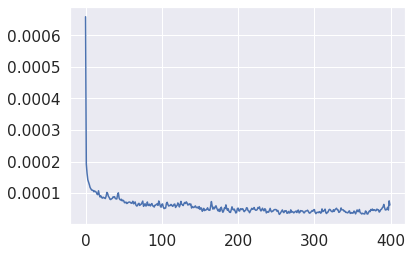

Epoch # 0 , loss = 7.52e-05, mean test error = 1.52e-01
Epoch # 10 , loss = 3.03e-05, mean test error = 1.38e-01
Epoch # 20 , loss = 2.49e-05, mean test error = 1.36e-01
Epoch # 30 , loss = 2.22e-05, mean test error = 1.35e-01
Epoch # 40 , loss = 2.06e-05, mean test error = 1.35e-01
Epoch # 50 , loss = 1.95e-05, mean test error = 1.35e-01
Epoch # 60 , loss = 1.86e-05, mean test error = 1.35e-01
Epoch # 70 , loss = 1.80e-05, mean test error = 1.35e-01
Epoch # 80 , loss = 1.86e-05, mean test error = 1.36e-01
Epoch # 90 , loss = 1.98e-05, mean test error = 1.39e-01
Epoch # 100 , loss = 2.32e-05, mean test error = 1.39e-01
Epoch # 110 , loss = 2.13e-05, mean test error = 1.41e-01
Epoch # 120 , loss = 1.88e-05, mean test error = 1.37e-01
Epoch # 130 , loss = 1.86e-05, mean test error = 1.39e-01
Epoch # 140 , loss = 1.74e-05, mean test error = 1.39e-01
Epoch # 150 , loss = 1.72e-05, mean test error = 1.39e-01
Epoch # 160 , loss = 1.78e-05, mean test error = 1.40e-01
Epoch # 170 , loss = 1.79

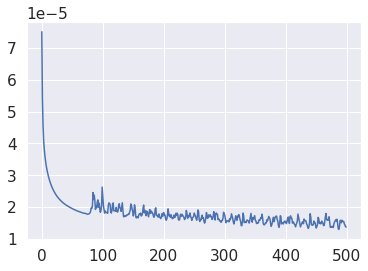

In [ ]:
loss_list = train_conv_net(conv_net, X_data_train_split, Y_data_train_split,
                           X_data_test.float(), Y_data_test.float(),
                           num_epoch=400, lr = 5e-4, print_freq= 50)
plt.plot(loss_list)
plt.show()
loss_list = train_conv_net(conv_net, X_data_train_split, Y_data_train_split,
                           X_data_test.float(), Y_data_test.float(),
                           num_epoch=500, lr = 5e-5, print_freq= 50)
plt.plot(loss_list)

Я пробовал обучать дольше - ошибка на тесте уже не убывает.

Нарисуем результат на тестовой выборке вместе с ошибкой. Качественно выглядит неплохо.

relative error = 7.79e-02


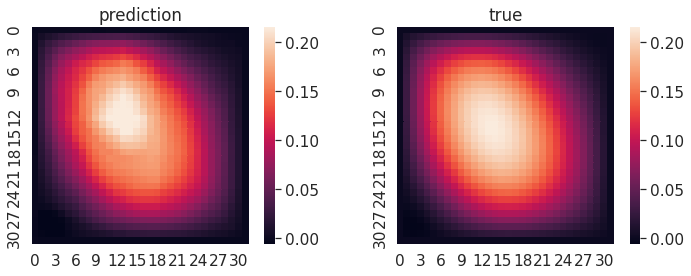

Text(0.5, 1.0, 'Разность')

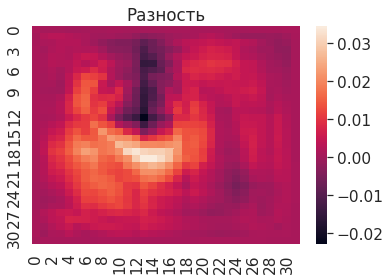

In [ ]:
conv_net.eval()
index = 5
u = conv_net(X_data_test[index].view(1, 1, N+1, N+1).float()).cpu()
u_true = Y_data_test[index]
delta = u_true.view(N+1, N+1).numpy() - u.detach().view(N+1, N+1).numpy()

rel_error = np.linalg.norm(delta, 'fro') / np.linalg.norm(u_true.view(N+1, N+1).numpy(), 'fro')
print('relative error = {0:5.2e}'.format(rel_error))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 4))
vmin = np.min(u_true.view(N+1, N+1).numpy())
vmax = np.max(u_true.view(N+1, N+1).numpy())
sns.heatmap(u.detach().view(N+1, N+1).numpy(), ax = ax1, vmin = vmin, vmax = vmax)
sns.heatmap(u_true.view(N+1, N+1).numpy(), ax = ax2, vmin = vmin, vmax = vmax)
ax1.set_aspect('equal')
ax1.set_title('prediction')
ax2.set_aspect('equal')
ax2.set_title('true')
plt.show()


sns.heatmap(delta)
plt.title('Разность')



Сохраняем модель на всякий случай.

In [ ]:
torch.save(conv_net,'conv_net_relu.pickle')
from google.colab import files
files.download('conv_net_relu.pickle')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type ConvNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Архитектура вида encoder-decoder 

Для сравнения попробуем архитектуру с bottleneck , чтобы использовать свертки небольшого размера, но при этом распространить информацию по всей области. 

Я взял архитектуру похожую на SegNet, попробовал применить сигмоиды, т.к. кажется, что они больше подходят для получения гладких картинок, чем ReLU.

In [ ]:
# Архитектура с сужением

class ConvNet2(nn.Module):
    def __init__(self, mesh_size = 32):
        super().__init__()
        self.mesh_size = mesh_size

        self.module_list = nn.ModuleList()
        # 1, 32 - > 16
        self.module_list.append(
            nn.Sequential(
              nn.Conv2d(in_channels = 1, out_channels = 16, 
                                   kernel_size= (3, 3), padding = 1),
              nn.BatchNorm2d(16),
              nn.Sigmoid(),
              # nn.Conv2d(in_channels = 16, out_channels = 16, 
              #                      kernel_size= (3, 3), padding = 1),
              # nn.BatchNorm2d(16),
              # nn.Sigmoid(),
              nn.MaxPool2d(kernel_size = 2, stride = 2)
            )
        )
        # 2, 16 -> 8
        self.module_list.append(
            nn.Sequential(
              nn.Conv2d(in_channels = 16, out_channels = 32, 
                                   kernel_size= (3, 3), padding = 1),
              nn.BatchNorm2d(32),
              nn.Sigmoid(),
              # nn.Conv2d(in_channels = 32, out_channels = 32, 
              #                      kernel_size= (3, 3), padding = 1),
              # nn.BatchNorm2d(32),
              # nn.Sigmoid(),
              nn.MaxPool2d(kernel_size = 2, stride = 2)
            )
        )

        # 3, 8 -> 4
        self.module_list.append(
            nn.Sequential(
              nn.Conv2d(in_channels = 32, out_channels = 64, 
                                   kernel_size= (3, 3), padding = 1),
              nn.BatchNorm2d(64),
              nn.Sigmoid(),
              # nn.Conv2d(in_channels = 64, out_channels = 64, 
              #                      kernel_size= (3, 3), padding = 1),
              # nn.BatchNorm2d(64),
              # nn.Sigmoid(),
              nn.MaxPool2d(kernel_size = 2, stride = 2)
            )
        )

        # Decoder part
        # 4, 4 -> 8
        self.module_list.append(
            nn.Sequential(
              nn.UpsamplingBilinear2d(scale_factor = 2),
              nn.Conv2d(in_channels = 64, out_channels = 32, 
                        kernel_size= (3, 3), padding = 1),
              nn.BatchNorm2d(32),
              nn.Sigmoid()
              # nn.Conv2d(in_channels = 32, out_channels = 32, 
              #           kernel_size= (3, 3), padding = 1),
              # nn.BatchNorm2d(32),
              # nn.Sigmoid()
            )
        )
        # 5, 8 -> 16
        self.module_list.append(
            nn.Sequential(
              nn.UpsamplingBilinear2d(scale_factor = 2),
              nn.Conv2d(in_channels = 32, out_channels = 16, 
                        kernel_size= (3, 3), padding = 1),
              nn.BatchNorm2d(16),
              nn.Sigmoid()
              # nn.Conv2d(in_channels = 16, out_channels = 16, 
              #           kernel_size= (3, 3), padding = 1),
              # nn.BatchNorm2d(16),
              # nn.Sigmoid()
            )
        )

        # 6, 16 -> 32
        self.module_list.append(
            nn.Sequential(
              nn.UpsamplingBilinear2d(scale_factor = 2),
              nn.Conv2d(in_channels = 16, out_channels = 8, 
                        kernel_size= (3, 3), padding = 1),
              nn.BatchNorm2d(8),
              nn.Sigmoid()
              # nn.Conv2d(in_channels = 8, out_channels = 8, 
              #           kernel_size= (3, 3), padding = 1),
              # nn.BatchNorm2d(8),
              # nn.Sigmoid()
            )
        )

        # 7, 32 -> 32
        self.module_list.append(
            nn.Sequential(
              nn.Conv2d(in_channels = 8, out_channels = 1, 
                        kernel_size= (1, 1), padding = 0)
            )
        )

    def forward(self, v):
        u = v.to(device)
        for layer in self.module_list:
            u = layer(u)
        return u


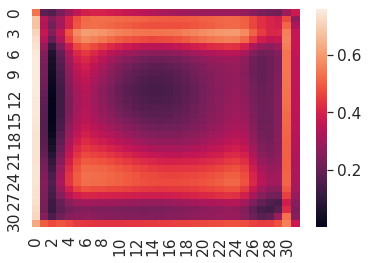

In [ ]:
conv_net2 = ConvNet2().to(device)
u = conv_net2(X_data_train[0].view(1, 1, N+1, N+1).float())
sns.heatmap(u.cpu().detach().view(N+1, N+1).numpy())

Epoch # 0 , loss = 1.34e-03, mean test error = 3.59e+00
Epoch # 50 , loss = 6.84e-05, mean test error = 4.21e-01
Epoch # 100 , loss = 6.05e-05, mean test error = 1.83e-01
Epoch # 150 , loss = 3.86e-05, mean test error = 1.28e-01
Epoch # 200 , loss = 2.75e-05, mean test error = 2.05e-01
Epoch # 250 , loss = 2.63e-05, mean test error = 8.51e-02
Epoch # 300 , loss = 2.51e-05, mean test error = 1.51e-01
Epoch # 350 , loss = 2.13e-05, mean test error = 1.36e-01
Epoch # 399 , loss = 2.61e-05


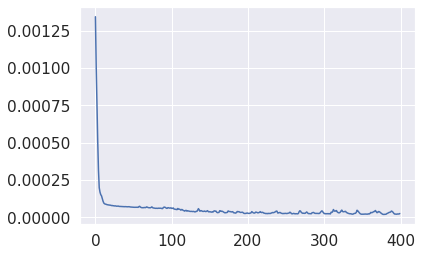

Epoch # 0 , loss = 2.39e-05, mean test error = 7.54e-02
Epoch # 50 , loss = 1.88e-05, mean test error = 6.21e-02
Epoch # 100 , loss = 1.77e-05, mean test error = 6.32e-02
Epoch # 150 , loss = 1.66e-05, mean test error = 6.54e-02
Epoch # 200 , loss = 1.52e-05, mean test error = 5.69e-02
Epoch # 250 , loss = 1.57e-05, mean test error = 7.23e-02
Epoch # 300 , loss = 1.35e-05, mean test error = 5.97e-02
Epoch # 350 , loss = 1.41e-05, mean test error = 5.56e-02
Epoch # 400 , loss = 1.43e-05, mean test error = 7.37e-02
Epoch # 450 , loss = 1.29e-05, mean test error = 6.93e-02
Epoch # 499 , loss = 1.22e-05


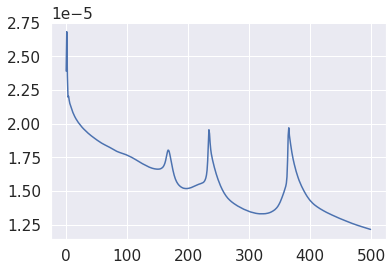

In [ ]:
loss_list = train_conv_net(conv_net2, X_data_train_split, Y_data_train_split,
                           X_data_test.float(), Y_data_test.float(),
                           num_epoch=400, lr = 5e-4, print_freq= 50)
plt.plot(loss_list)
plt.show()
loss_list = train_conv_net(conv_net2, X_data_train_split, Y_data_train_split,
                           X_data_test.float(), Y_data_test.float(),
                           num_epoch=500, lr = 5e-5, print_freq= 50)
plt.plot(loss_list)

Эта архитектура обучается гораздо быстрее первой, при этом даёт ошибку на тесте почти в 2 раза меньше, чем первая.

Рисуем предсказание на тесте вместе с точным решением.

relative error = 4.11e-02


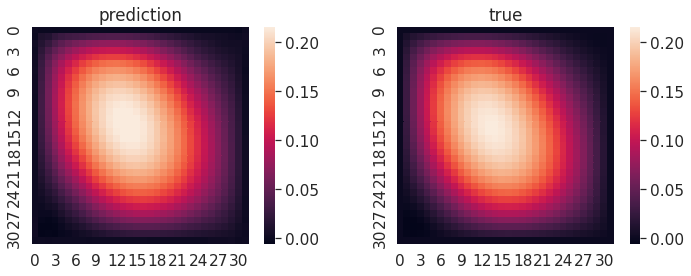

Text(0.5, 1.0, 'Разность')

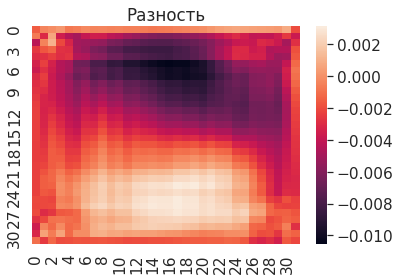

In [ ]:
conv_net2.eval()
index = 5
u = conv_net2(X_data_test[index].view(1, 1, N+1, N+1).float()).cpu()
u_true = Y_data_test[index]
delta = u_true.view(N+1, N+1).numpy() - u.detach().view(N+1, N+1).numpy()

rel_error = np.linalg.norm(delta, 'fro') / np.linalg.norm(u_true.view(N+1, N+1).numpy(), 'fro')
print('relative error = {0:5.2e}'.format(rel_error))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 4))
vmin = np.min(u_true.view(N+1, N+1).numpy())
vmax = np.max(u_true.view(N+1, N+1).numpy())
sns.heatmap(u.detach().view(N+1, N+1).numpy(), ax = ax1, vmin = vmin, vmax = vmax)
sns.heatmap(u_true.view(N+1, N+1).numpy(), ax = ax2, vmin = vmin, vmax = vmax)
ax1.set_aspect('equal')
ax1.set_title('prediction')
ax2.set_aspect('equal')
ax2.set_title('true')
plt.show()


sns.heatmap(delta)
plt.title('Разность')


Сохраняем модель на всякий случай

In [ ]:
torch.save(conv_net2,'conv_net2.pickle')
from google.colab import files
files.download('conv_net2.pickle')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type ConvNet2. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Теперь проведём такой эксперимент: попробуем применить нашу сеть для функции $f(x,y)$, которая вообще не принадлежит тому семейству, из которого мы брали выборку.

Это покажет, насколько хорошая обобщающая способность у нашей модели.

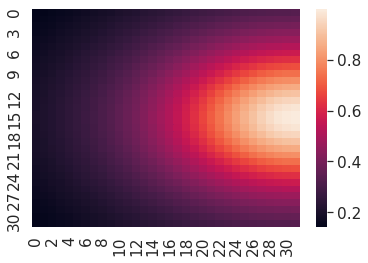

In [ ]:
f = lambda x, y: 1/ (1 + (x-1)**2 + 2*y**2)
fval = f(X, Y)
sns.heatmap(fval)  

В следующем окне запускаем предсказание для такой правой части. 

Относительная ошибка в норме Фробениуса составляет всего несколько процентов (2-4). 

Думаю, это подтверждает, что сеть действительно выучила нужное отображение, а не просто приспособилась к выборке, сгенерированной по частичным суммам рядов Фурье. 

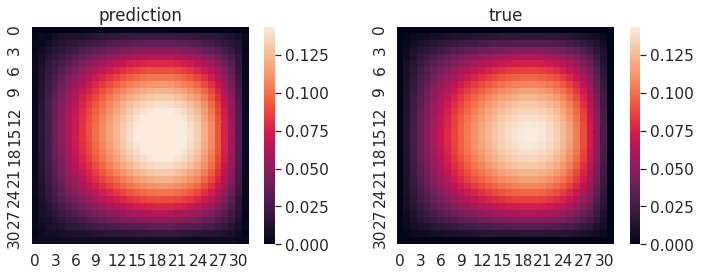

Error = 5.97e-02


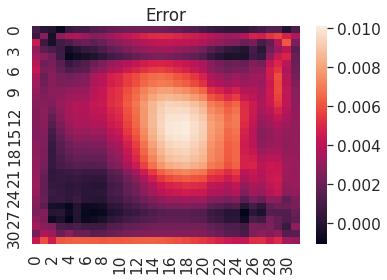

In [ ]:
u = np.zeros(X.shape)

h = 2 / N # space step
tau = 0.1 * h**2 # time step

for it in tqdm(range(10**4)):
    u, _ = get_next_step(u, h, tau, fval)

u_ex = np.copy(u)

fval_torch = torch.from_numpy(fval).view(1, 1, N+1, N+1).float()

u_ap = conv_net2(fval_torch).cpu().detach().view(N+1, N+1).numpy()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 4))

vmin = np.min(u_ex)
vmax = np.max(u_ex)
sns.heatmap(u_ap, ax = ax1, vmin = vmin, vmax = vmax)
sns.heatmap(u_ex, ax = ax2, vmin = vmin, vmax = vmax)
ax1.set_aspect('equal')
ax1.set_title('prediction')
ax2.set_aspect('equal')
ax2.set_title('true')
plt.show()

sns.heatmap(u_ap - u_ex)
plt.title('Error')

print('Error = {0:5.2e}'.format(
    np.linalg.norm(u_ap - u_ex, 'fro') / np.linalg.norm(u_ex, 'fro')
))

# 2. Экстраполяция решения по времени

В этом разделе тестируется другая идея (я её сам придумал) для другой задачи.

Конечно-разностный метод даёт нам решения $u(t^n, x, y)$ в последовательные моменты времени. Идея заключается в том, чтобы обучить нейросеть по скалярному входу $t$ предсказывать решение в момент времени $t$ на большом наборе решений. После этого, можно подставить большОе $t$ и надеяться, что нейросеть правильно экстраполирует решение в будущее.

Надежда эта основана на том, что для простых линейных задач для уравнения Пуассона решение можно разложить по собственным функциям оператора Лапласа: 
$$
u(t, x, y) = \sum_{k=1}^\infty c_k(t) \psi_k(x,y) \approx \sum_{k=1}^M c_k(t) \psi_k(x,y)
$$
где $c_k(t)$ - какая-то плавно меняющаяся функция.

Т.е. априори известно, что решение хорошо аппроксимируется линейной комбинацией небольшого числа простых функций. Поэтому, кажется, что если сделать архитектуру такого же вида, то в процессе обучения нейросеть должна сама восстановить эти зависимости.

Ниже генерируем набор данных - просто сохраняем решение на каждой итерации.

In [ ]:
n_of_time_steps = 10 * 10 ** 3
N = 63
residual = np.zeros(n_of_time_steps + 1)
print_every = 1 # 


X = np.linspace(-1, 1, N + 1)
Y = np.linspace(-1, 1, N + 1)



X, Y = np.meshgrid(X, Y)
f_fun = lambda x, y:   np.sin(X + Y**2) / (1 + x **2 + y**2)
f_val = f_fun(X, Y)
u_in = np.sin(X + Y ** 2) # Boundary condition
u_in[1:N, 1:N] = 0 # Initial condition 

u = u_in

h = 2 / N # space step
tau = 0.1 * h**2 # time step
history = [] #np.zeros((n_of_time_steps, N + 1, N + 1))
import copy
for i in tqdm(range(n_of_time_steps)):
    if (i % print_every == 0):
        history.append(copy.deepcopy(u))
    u, residual[i] = get_next_step(u, h, tau, f_val)
residual[-1] = compute_residual(u, h, tau, f_val)

Построим график убывания невязки. Видно, что сходимость довольно медленная.

Text(0, 0.5, '$\\Vert R \\Vert$')

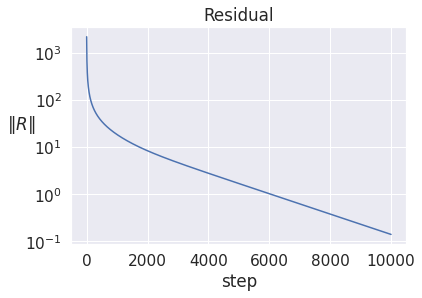

In [ ]:
plt.semilogy(residual)
plt.title('Residual')
plt.xlabel('step')
plt.ylabel('$\Vert R \Vert$', rotation = 0)

Ниже сделана интерактивность, чтобы можно было посмотреть, как меняется решение от итерации к итерации. В начале оно меняется сильно, потом уже на глаз трудно заметить изменения

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

def plot(index):
    # plt.figure(figsize=(8, 8))
    sns.heatmap(history[index])
    plt.show()
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(X, Y, history[index], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

In [ ]:
  interact(plot, index=(0, n_of_time_steps - 1))

interactive(children=(IntSlider(value=4999, description='index', max=9999), Output()), _dom_classes=('widget-i…

<function __main__.plot>

Реализуем свою архитектуру сети. 

1.   Первая часть: из числа с помощью нескольких полносвязных слоёв получаем маломерный вектор
2.   Вторая часть: декодируем маломерный вектор в изображение с помощью convolutional decoder архитектуры

![Замещающий текст](https://drive.google.com/file/d/1Q9iK-bvhcpdIirTkgCJ9cBPVwftz1oKi/view?usp=sharing)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

class PoissonNet(nn.Module):
    def __init__(self, mesh_size, n_of_dense = 3, dense_width = 10, low_dim = 4):
        super().__init__()
        self.n_of_dense = n_of_dense
        self.dense_width = dense_width
        self.low_dim = low_dim
        self.mesh_size = mesh_size

        self.dense_list = nn.ModuleList()
        self.dense_list.append(
            nn.Sequential(
                nn.Linear(1, self.dense_width),
                nn.Sigmoid()
            )
        )
        for i in range(n_of_dense - 1):
          self.dense_list.append(
              nn.Sequential(
                  nn.Linear(self.dense_width, self.dense_width),
                  nn.Sigmoid()
              )
          )
        # Последний слой без сигмоиды
        self.dense_list.append(
            nn.Sequential(
                nn.Linear(self.dense_width, self.low_dim)
            )
        )

        # Decoder
        self.decoder_list = nn.ModuleList()

        self.decoder_list.append(
            nn.Sequential(
                nn.UpsamplingBilinear2d(scale_factor = 2), # 1 -> 2
                nn.Conv2d(in_channels = self.low_dim, out_channels = self.low_dim, 
                                   kernel_size= (3,3), padding = 1, padding_mode ='zeros'),
                nn.BatchNorm2d(self.low_dim),
                nn.ReLU(), 
                nn.Conv2d(in_channels = self.low_dim, out_channels = self.low_dim, 
                                   kernel_size= (3,3), padding = 1, padding_mode ='zeros'),
                nn.BatchNorm2d(self.low_dim),
                nn.ReLU()
            )
        )

        self.decoder_list.append(
            nn.Sequential(
                nn.UpsamplingBilinear2d(scale_factor = 2), # 2 -> 4
                nn.Conv2d(in_channels = self.low_dim, out_channels = self.low_dim, 
                                   kernel_size= (3,3), padding = 1, padding_mode ='zeros'),
                nn.BatchNorm2d(self.low_dim),
                nn.ReLU(), 
                nn.Conv2d(in_channels = self.low_dim, out_channels = self.low_dim, 
                                   kernel_size= (3,3), padding = 1, padding_mode ='zeros'),
                nn.BatchNorm2d(self.low_dim),
                nn.ReLU()
            )
        )

        self.decoder_list.append(
            nn.Sequential(
                nn.UpsamplingBilinear2d(scale_factor = 2), # 4 -> 8
                nn.Conv2d(in_channels = self.low_dim, out_channels = self.low_dim, 
                                   kernel_size= (3,3), padding = 1, padding_mode ='zeros'),
                nn.BatchNorm2d(self.low_dim),
                nn.ReLU(), 
                nn.Conv2d(in_channels = self.low_dim, out_channels = self.low_dim, 
                                   kernel_size= (3,3), padding = 1, padding_mode ='zeros'),
                nn.BatchNorm2d(self.low_dim),
                nn.ReLU()
            )
        )

        self.decoder_list.append(
            nn.Sequential(
                nn.UpsamplingBilinear2d(scale_factor = 2), # 8 -> 16
                nn.Conv2d(in_channels = self.low_dim, out_channels = self.low_dim, 
                                   kernel_size= (3,3), padding = 1, padding_mode ='zeros'),
                nn.BatchNorm2d(self.low_dim),
                nn.ReLU(), 
                nn.Conv2d(in_channels = self.low_dim, out_channels = self.low_dim, 
                                   kernel_size= (3,3), padding = 1, padding_mode ='zeros'),
                nn.BatchNorm2d(self.low_dim),
                nn.ReLU()
            )
        )

        self.decoder_list.append(
            nn.Sequential(
                nn.UpsamplingBilinear2d(scale_factor = 2), # 16 -> 32
                nn.Conv2d(in_channels = self.low_dim, out_channels = self.low_dim, 
                                   kernel_size= (3,3), padding = 1, padding_mode ='zeros'),
                nn.BatchNorm2d(self.low_dim),
                nn.ReLU(), 
                nn.Conv2d(in_channels = self.low_dim, out_channels = self.low_dim, 
                                   kernel_size= (3,3), padding = 1, padding_mode ='zeros'),
                nn.BatchNorm2d(self.low_dim),
                nn.ReLU()
            )
        )

        self.decoder_list.append(
            nn.Sequential(
                nn.UpsamplingBilinear2d(scale_factor = 2), # 32 -> 64
                nn.Conv2d(in_channels = self.low_dim, out_channels = self.low_dim, 
                                   kernel_size= (3,3), padding = 1, padding_mode ='zeros'),
                nn.BatchNorm2d(self.low_dim),
                nn.ReLU(),
                nn.Conv2d(in_channels = self.low_dim, out_channels = 1, 
                                   kernel_size= (3,3), padding = 1, padding_mode ='zeros')
            )
        )
    def encode(self, v):
        # -------------------------------
        # First part: get low_dim vector
        # v = t
        for dense_layer in self.dense_list:
            v = dense_layer(v)
        # Сжатое представление решения
        return v

    def decode(self, v):
        v = v.view((-1, self.low_dim, 1, 1))
        #-------------------------------
        # Second part: decode into image
        for decode_layer in self.decoder_list:
            v = decode_layer(v)
        
        return v

    def forward(self, v):
        # -------------------------------
        # First part: get low_dim vector
        # v = t
        v = v.to(device)
        for dense_layer in self.dense_list:
            v = dense_layer(v)
        # Сжатое представление решения
        hidden = copy.deepcopy(v.detach())
        #------------------------------
        v = v.view((-1, self.low_dim, 1, 1))
        #-------------------------------
        # Second part: decode into image
        for decode_layer in self.decoder_list:
            v = decode_layer(v)
        
        return v, hidden

In [ ]:
# Функция для разбиения на батчи
def split_to_batches2(t, u, batch_size):
    t_split = []
    u_split = []
    for i in range(len(t)  // batch_size):
        t_torch = t[i * batch_size : (i+1) * batch_size]
        t_torch = t_torch.view(t_torch.shape[0], 1)

        u_torch = u[i * batch_size : (i+1) * batch_size]
        u_torch = u_torch.view(u_torch.shape[0], 1, u_torch.shape[2], u_torch.shape[3])

        t_split.append(t_torch)
        u_split.append(u_torch)


    if(len(t) > (i+1) * batch_size):
        t_torch = t[(i+1) * batch_size :]
        t_torch = t_torch.view(t_torch.shape[0], 1)

        u_torch = u[(i+1) * batch_size : ]
        u_torch = u_torch.view(u_torch.shape[0], 1, u_torch.shape[2], u_torch.shape[3])

        t_split.append(t_torch)
        u_split.append(u_torch)
    return t_split, u_split


# Loss
def my_loss_fun_poisson(u_true, u_pred):
    delta = u_true - u_pred
    loss = (torch.sum(delta**2, dim = (1,2,3)) / (u_true.shape[2] * u_true.shape[3]))**0.5
    loss = torch.mean(loss)
    return loss

# Вычисляем среднюю относительную ошибку по всей обучающей выборке.
def compute_mean_rel_error(model, t_data, u_data):
    model.eval()
    mean_err = 0
    tot_size = 0
    for t, u_true in zip(t_data, u_data):
        u_pred, _ = model(t.to(device))
        u_pred = u_pred.detach().cpu()
        for i in range(len(t)):
            tot_size += 1 
            mean_err += torch.norm(
                (u_true[i, :, :, :] - u_pred[i, :, :, :])
                ) / torch.norm(u_true[i, :, :, :])
    mean_err = mean_err / tot_size
    return mean_err

def train_poisson_net(model, num_epoch, t_train, u_train, t_test, u_test, loss_fun = my_loss_fun_poisson,
          lr = 1e-4, print_every = 1):
    loss_list = []
    model.train()
    tot_size = 0
    for t in t_train:
        tot_size += len(t)

    for epoch in range(num_epoch):
        avg_loss = 0
        model.train()
        for t, u in zip(t_train, u_train):
            u = u.to(device)
            t = t.to(device)

            opt.zero_grad()
            u_pred, _ = model(t)
            loss = loss_fun(u_pred, u)
            loss.backward()
            opt.step()
            avg_loss += loss 
        avg_loss = avg_loss / tot_size
        loss_list.append(avg_loss)
        if (epoch % print_every == 0):
            mean_error_train = compute_mean_rel_error(model, t_train, u_train)
            mean_error_test = compute_mean_rel_error(model, t_test, u_test)
            print('Epoch # {0:d} , loss = {1:5.2e}, mean train error = {2:5.2e}, \
                  mean test error = {3:5.2e}'.
                  format(epoch, avg_loss, mean_error_train, mean_error_test))
    print('Epoch # {0:d} , loss = {1:5.2e}'.format(epoch, avg_loss))
    return loss_list

In [ ]:
a = torch.rand(2,2,2)
print(torch.norm(a, dim = (1,2)))

tensor([1.5156, 0.3435])


In [ ]:
history_torch = torch.zeros([len(history), 1, N+1, N+1])
for i in range(len(history)):
    history_torch[i, 0, :, :] = torch.from_numpy(history[i])
print(history_torch.shape)

torch.Size([10000, 1, 64, 64])


In [ ]:
t_torch = torch.linspace(0, 1, steps = n_of_time_steps)
t_torch = t_torch.view(-1, 1)
skip = 100
train_size = 1000
step = 4

# Берём обучающую выборку
u_train = history_torch[skip : skip + step * train_size : step, :, :, :]
t_train = t_torch[skip : skip + step * train_size : step, :]

# Тестовая выборка: это решения на всех следующих шагах по времени
u_test = [history_torch[skip + step * train_size : , :, :, :]]
t_test = [t_torch[skip + step * train_size :, :]]

t_train_split, u_train_split = split_to_batches2(t_train, u_train, len(t_train))

cuda
t0 =  tensor([0.5000])
torch.Size([1, 1, 64, 64])


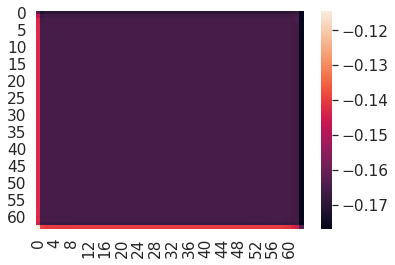

In [ ]:
from torchsummary import summary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
print(device)

poisson_net = PoissonNet(mesh_size = 32, dense_width= 5, low_dim = 4).to(device)
# summary(model, input_size= [1])
poisson_net.eval()


t0 = torch.FloatTensor([0.5])
print('t0 = ', t0)
# t0 = t0.view(1,1,1,1)
t0.to(device)
v,_ = poisson_net(t0)
print(v.shape)
v_numpy = v.cpu().detach().numpy()
v_numpy = v_numpy[0, 0, :, :]
sns.heatmap(v_numpy)

Epoch # 0 , loss = 6.72e-04, mean train error = 1.16e+00,                   mean test error = 1.15e+00
Epoch # 50 , loss = 1.44e-04, mean train error = 3.61e-01,                   mean test error = 2.30e-01
Epoch # 99 , loss = 6.74e-05


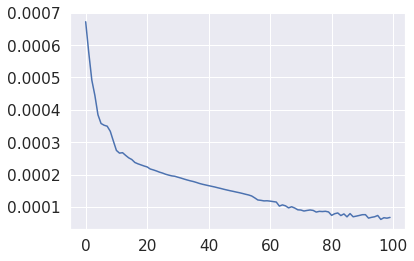

Epoch # 0 , loss = 5.75e-05, mean train error = 2.66e-01,                   mean test error = 2.77e-01
Epoch # 200 , loss = 3.12e-05, mean train error = 7.06e-02,                   mean test error = 1.22e-01
Epoch # 400 , loss = 2.34e-05, mean train error = 4.81e-02,                   mean test error = 1.33e-01
Epoch # 600 , loss = 1.98e-05, mean train error = 3.96e-02,                   mean test error = 1.50e-01
Epoch # 800 , loss = 1.85e-05, mean train error = 3.68e-02,                   mean test error = 1.61e-01
Epoch # 999 , loss = 1.63e-05


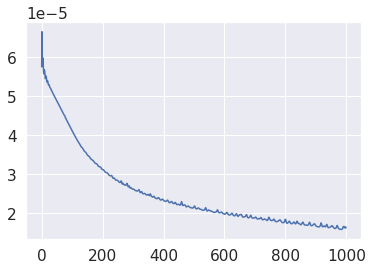

Epoch # 0 , loss = 1.61e-05, mean train error = 4.03e-02,                   mean test error = 1.80e-01
Epoch # 100 , loss = 1.56e-05, mean train error = 3.08e-02,                   mean test error = 1.71e-01
Epoch # 200 , loss = 1.54e-05, mean train error = 3.06e-02,                   mean test error = 1.71e-01
Epoch # 300 , loss = 1.51e-05, mean train error = 3.07e-02,                   mean test error = 1.70e-01
Epoch # 400 , loss = 1.48e-05, mean train error = 3.00e-02,                   mean test error = 1.70e-01
Epoch # 500 , loss = 1.45e-05, mean train error = 3.04e-02,                   mean test error = 1.68e-01
Epoch # 600 , loss = 1.42e-05, mean train error = 2.98e-02,                   mean test error = 1.64e-01
Epoch # 700 , loss = 1.38e-05, mean train error = 2.81e-02,                   mean test error = 1.58e-01
Epoch # 800 , loss = 1.35e-05, mean train error = 2.69e-02,                   mean test error = 1.50e-01
Epoch # 900 , loss = 1.32e-05, mean train error = 2.70e-0

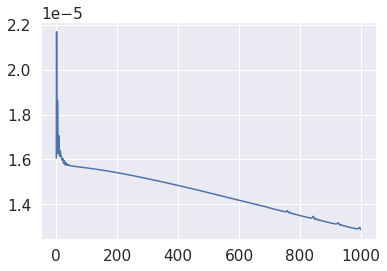

In [ ]:
poisson_net.to(device)
loss_list = train_poisson_net(poisson_net, 200, t_train_split, u_train_split, 
                              t_test, u_test, loss_fun = my_loss_fun_poisson, lr=1e-2,
                              print_every = 50
                              )
plt.plot(loss_list)
plt.show()

loss_list = train_poisson_net(poisson_net, 1000, t_train_split, u_train_split, 
                              t_test, u_test, loss_fun = my_loss_fun_poisson, lr=1e-3,
                              print_every = 200
                              )
plt.plot(loss_list)
plt.show()

loss_list = train_poisson_net(poisson_net, 1000, t_train_split, u_train_split, 
                              t_test, u_test, loss_fun = my_loss_fun_poisson, lr=2e-4,
                              print_every = 100
                              )
plt.plot(loss_list)
plt.show()

Нарисуем рядом точное решение и предсказание нейросети. 

Видно, что с увеличением времени $t$ ошибка растет, как и следовало ожидать, но в целом поведение решения, которое выдаёт нейросеть правильное.

Мне не хватило времени, чтобы подробно исследовать, как зависит качество модели от разных параметров архитектуры - так что есть ещё большой потенциал для улучшения.

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

def plot_compare(model, index):
    # plt.figure(figsize=(8, 8))
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (16, 4))
    vmin = np.min(history[index])
    vmax = np.max(history[index])
    sns.heatmap(history[index], ax = ax1, vmin = vmin, vmax = vmax)
    ax1.set_title('True')
    ax1.set_aspect('equal')
    model.eval()
    u_test, _ = model(t_torch[index])
    u_test = u_test.cpu()
    u_test_np = u_test.detach().view(N+1, N+1).numpy()
    sns.heatmap(u_test_np, ax = ax2, vmin = vmin, vmax = vmax)
    ax2.set_aspect('equal')
    ax2.set_title('Prediction')		  

    sns.heatmap(np.abs(u_test_np - history[index]), ax = ax3)
    ax3.set_aspect('equal')
    ax3.set_title('|Difference|')		  


interact(plot_compare, model = fixed(poisson_net), index=(0, n_of_time_steps - 1)) 

interactive(children=(IntSlider(value=4999, description='index', max=9999), Output()), _dom_classes=('widget-i…

<function __main__.plot_compare>

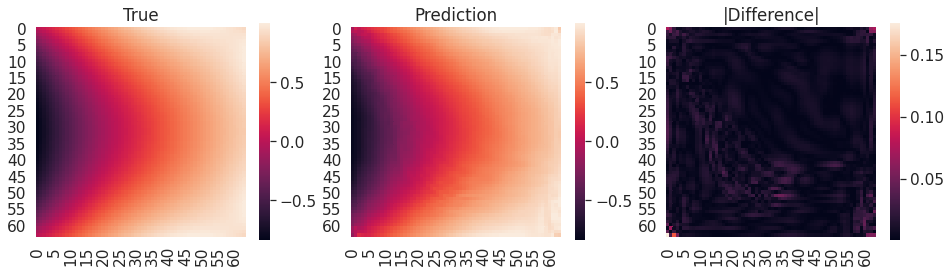

In [ ]:
plot_compare(poisson_net, 2000)

Нарисуем, как зависят компоненты bottleneck от времени. 

У меня чаще всего получалась линейная зависимость при обучении по маленькому отрезку времени (100 шагов), и нелинейная для бОльшего (1000). Причем нелинейная зависимость очень похожа на кусок сигмоиды.

На мой взгляд, главное, что коэффициенты меняются гладко, это говорит о том, что такой подход может быть успешно применён для экстраполяции в будущее. 

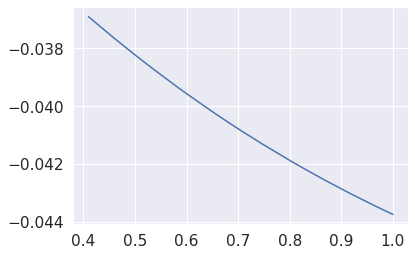

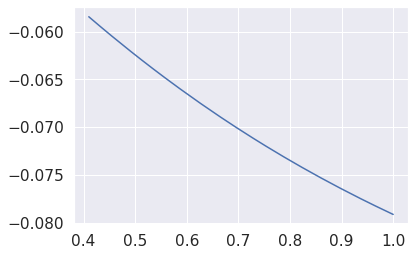

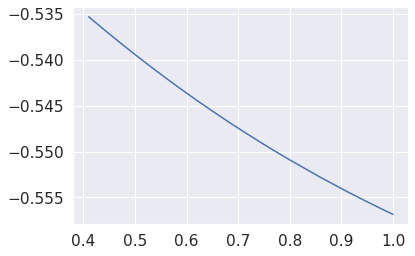

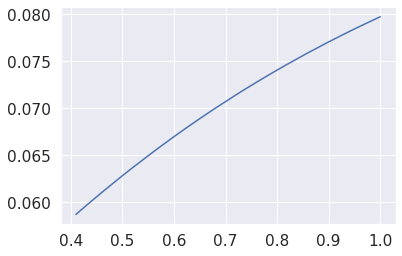

In [ ]:
_, v = poisson_net(t_test[0])
v = v.detach().cpu()

for j in range(poisson_net.low_dim):
    plt.plot(t_test[0], v[:, j])
    plt.plot()
    plt.show()

# Выводы

Были рассмотрены две задачи, связанные с численным решением уравнения Пуассона на структурированной сетке.

Для первой задачи были опробаны две архитектуры: архитектура из статьи, и новая архитектура типа Encoder-Decoder со слоями как в SegNet. 
Результат получился хороший: обе модели позволяют сразу предсказывать решение с точностью в несколько процентов. Интересно, что вторая сеть с маленьким числом слоёв даёт лучший результат.

Увеличение числа слоёв не давала заметного улучшения.

Во второй задаче использовалась придуманная мной архитектура, которая сначала по скалярному входу генерирует вектор скрытых признаков, потом разворачивает этот вектор в изображение. 
Результаты получились неплохие, есть потенциал для оптимизации архитектуры. 
В целом полученный результат уже можно попробовать использовать для ускорения сходимости, и для "архивации" нестационарного решения: можно обучать модель, которая запомнит набор решений на сетке в разные моменты времени, при 
этом количество параметров в сети очень мало, по сравнению с объёмом исходных данных.